In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de

2022-03-16 17:08:50.265063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 17:08:50.265127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:563: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [3]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

In [4]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
adata = adata[adata.obs.treatment != 'nan']

## Data summary plots

In [6]:
pd.crosstab(adata.obs['treatment'], adata.obs['patient'])

patient             patient_1  patient_2  patient_3  patient_4
treatment                                                     
BB94                        0          0          0       3898
DMSO                        0          0          0       2285
Gilteritinib                0          0          0       3932
IFNL                        0          0       4520       4836
IFNa (b_d)               3810       5914       4020       4760
IFNa_TNFa                3800          0       6526       4560
IFNg                     3556       4242       5787       4769
IFNg_TGFb2                  0          0       4389       4305
Sorafenib                3559          0       5010       5954
TGFb2                    3951       3891       5346       4891
TGFb2_Tirapazamine          0          0       3729       4884
TNFa                     3396       4044       5711       4265
TNFa_IFNg                3422          0       3752       4377
TNFa_TGFb2               2718          0       4321       4764
TNFa_Tirapazamine        4344          0       4547       3910
Tirapazamine             3222       2397       5172       5236
mock                     7297       5059      10670       8226
nan                         0          0      50114      28265

In [7]:
pd.crosstab(adata.obs['infected'], adata.obs['treatment'])

treatment  BB94  DMSO  Gilteritinib  IFNL  IFNa (b_d)  IFNa_TNFa   IFNg  \
infected                                                                  
False      1738     0          1956  5224        9833       6983  10019   
True       2160  2285          1976  4132        8671       7903   8335   

treatment  IFNg_TGFb2  Sorafenib  TGFb2  TGFb2_Tirapazamine  TNFa  TNFa_IFNg  \
infected                                                                       
False            4185       8027   8213                3878  8979       5550   
True             4509       6496   9866                4735  8437       6001   

treatment  TNFa_TGFb2  TNFa_Tirapazamine  Tirapazamine   mock  
infected                                                       
False            6112               6412          8197  14903  
True             5691               6389          7830  16349

In [9]:
adata.obs['infected'].value_counts()

True     111765
False    110209
Name: infected, dtype: int64

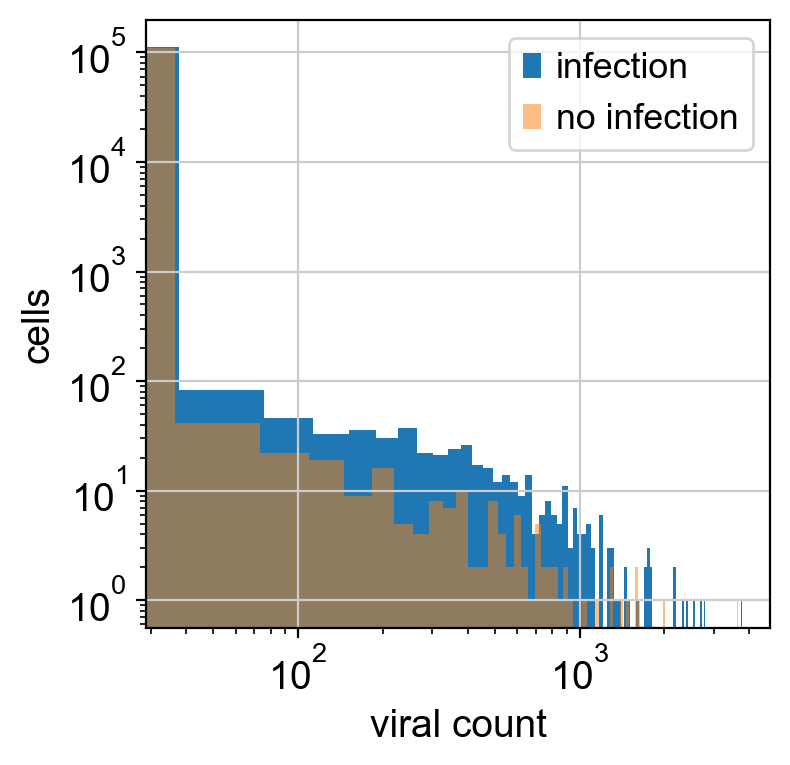

In [14]:
plt.hist(adata[adata.obs.infected == 'True'].obs.viral_counts.values, bins=100, label='infection')
plt.hist(adata[adata.obs.infected == 'False'].obs.viral_counts.values, bins=100, alpha=.5, label='no infection')
plt.xlabel('viral count')
plt.ylabel('cells')
plt.xscale('log')
plt.yscale('log')
plt.legend();

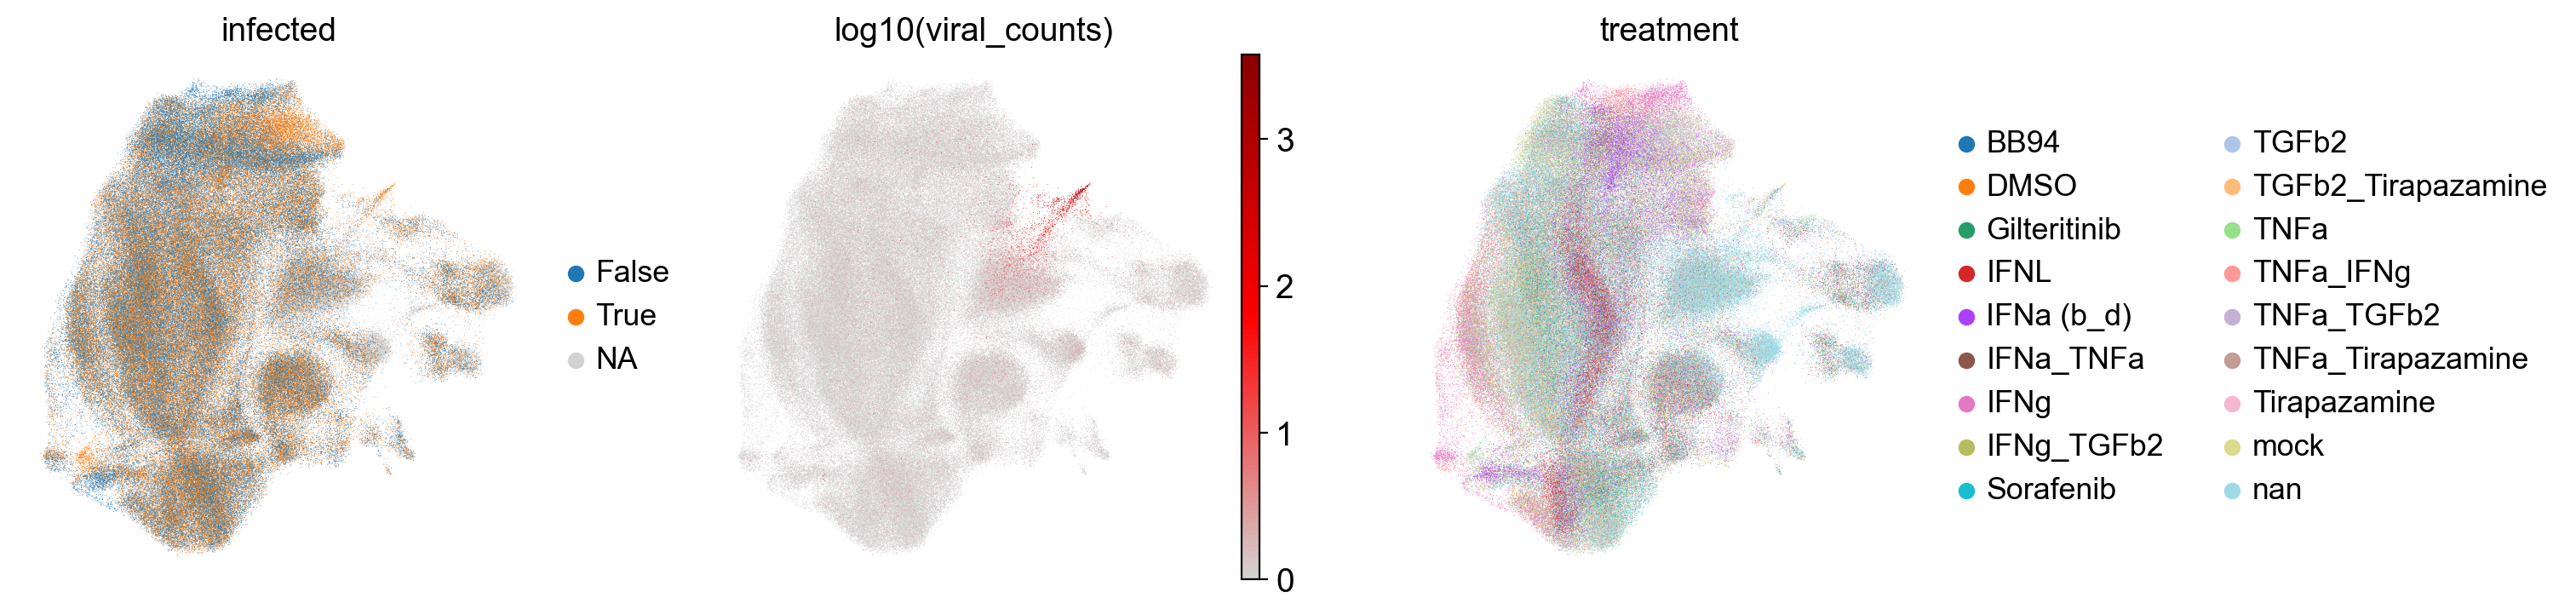

In [17]:
adata.obs['log10(viral_counts)'] = np.log10(adata.obs.viral_counts + 1)
sc.pl.umap(adata, color=['infected', 'log10(viral_counts)', 'treatment'], color_map=gray_red, ncols=3)

## Differential expression plots

TODO: consider taking top genes according to fold change instead of p-value.

In [5]:
from gprofiler import GProfiler
def enrich(query):
    gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

    return gp.profile(
        organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
        significance_threshold_method='fdr', 
        background=adata.var_names.tolist(),
        query=query, 
        no_evidences=False)

In [37]:
# compose dataframe for plotting
def plot_deg_heatmap(degs):
    enr_dfs = {}
    terms = []
    for k, genes in degs.items():
        df = enrich(genes)
        # add the most significant term to final list
        terms += df.sort_values('p_value').iloc[:1,:]['name'].values.tolist()
        # aggregate dfs
        df = df[['name', 'p_value']].set_index('name')
        df['p_value'] = -np.log10(df['p_value'])
        enr_dfs[k] = df

    enrichment = pd.concat(enr_dfs)
    enrichment = enrichment[enrichment.index.get_level_values('name').isin(terms)]  # filter to top terms
    enrichment = enrichment.unstack(level=-1).fillna(0)
    return enrichment.T.reset_index(level=0, drop=True)

### using rank_genes_groups

In [17]:
dfs = {}
degs = {}
for i in ['True', 'False']:
    viral_subset = adata[adata.obs.infected == i].copy()
    for ct in adata.obs.cell_type.unique():
        subset = viral_subset[viral_subset.obs.cell_type == ct]
        try:
            sc.tl.rank_genes_groups(subset, groupby='treatment', reference='mock', use_raw=False)
        except ValueError:  # not enough samples in one of the treatments
            continue

        # get all enrichment results per cell type
        for group in subset.obs.treatment.unique():
            if group != 'mock':
                dfs[(i, ct, group)] = sc.get.rank_genes_groups_df(subset, group=group)
                degs[(i, ct, group)] = \
                    dfs[(i, ct, group)]['names'].values.tolist()[:25] + dfs[(i, ct, group)]['names'].values.tolist()[-25:]

Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


In [14]:
# sns.set(font_scale=1.0)

Plot for patient 3+4 combined data.

In [31]:
%%time
df = plot_deg_heatmap(degs)

CPU times: user 11.7 s, sys: 866 ms, total: 12.6 s
Wall time: 8min 56s


In [69]:
feature = 'treatment'
row_colors = df.T.reset_index()['level_2'].map(dict(zip(adata.obs[feature].cat.categories, adata.uns[f'{feature}_colors'])))
sns.clustermap(
    df.T.reset_index(drop=True).T,  # colors don't show with multiindex
    cmap=gray_red,
    linewidths=.5,
    col_colors=row_colors,
    figsize=(60, 25)
)

In [68]:
sns.clustermap(
    df,
    cmap=gray_red,
    linewidths=.5,
    figsize=(60, 25)
)

#### Per patient, colored by whether genes went up or down

In [17]:
# # compose dataframe for plotting
# def plot_deg_heatmap_bi(dfs):
#     enr_dfs = {}
#     terms = []
#     for k, deg_df in dfs.items():
#         genes = list(deg_df.names.values[:25]) + list(deg_df.names.values[-25:])
#         df = enrich(list(genes))
#         # add the most significant term to final list
#         terms += df.sort_values('p_value').iloc[:1,:]['name'].values.tolist()
#         # aggregate dfs
#         df = df[['name', 'p_value']].set_index('name')
#         df['p_value'] = -np.log10(df['p_value'])
#         enr_dfs[k] = df

#     enrichment = pd.concat(enr_dfs)
#     enrichment = enrichment[enrichment.index.get_level_values('name').isin(terms)]  # filter to top terms
#     return enrichment

In [156]:
# %%time
# enrichment = plot_deg_heatmap_bi(patient_dicts['patient_3_dfs'])

# # plot according to up/down of genes
# plot_values = []
# for idx in enrichment.index:
#     condition_df = dfs[idx[:3]][['scores']]
#     plot_values.append(condition_df.head(25).sum().values[0] + condition_df.tail(25).sum().values[0])

# # replace p_value with the inverse if it is i 
# enrichment['p_value'] = [-v if plot_values[i] < 0 else v for i, v in enumerate(enrichment['p_value'].values)]
# enrichment = enrichment.unstack(level=-1).fillna(0)
# df = enrichment.T.reset_index(level=0, drop=True)

CPU times: user 8.91 s, sys: 812 ms, total: 9.72 s
Wall time: 4min 2s


<AxesSubplot:xlabel='None-None', ylabel='name'>

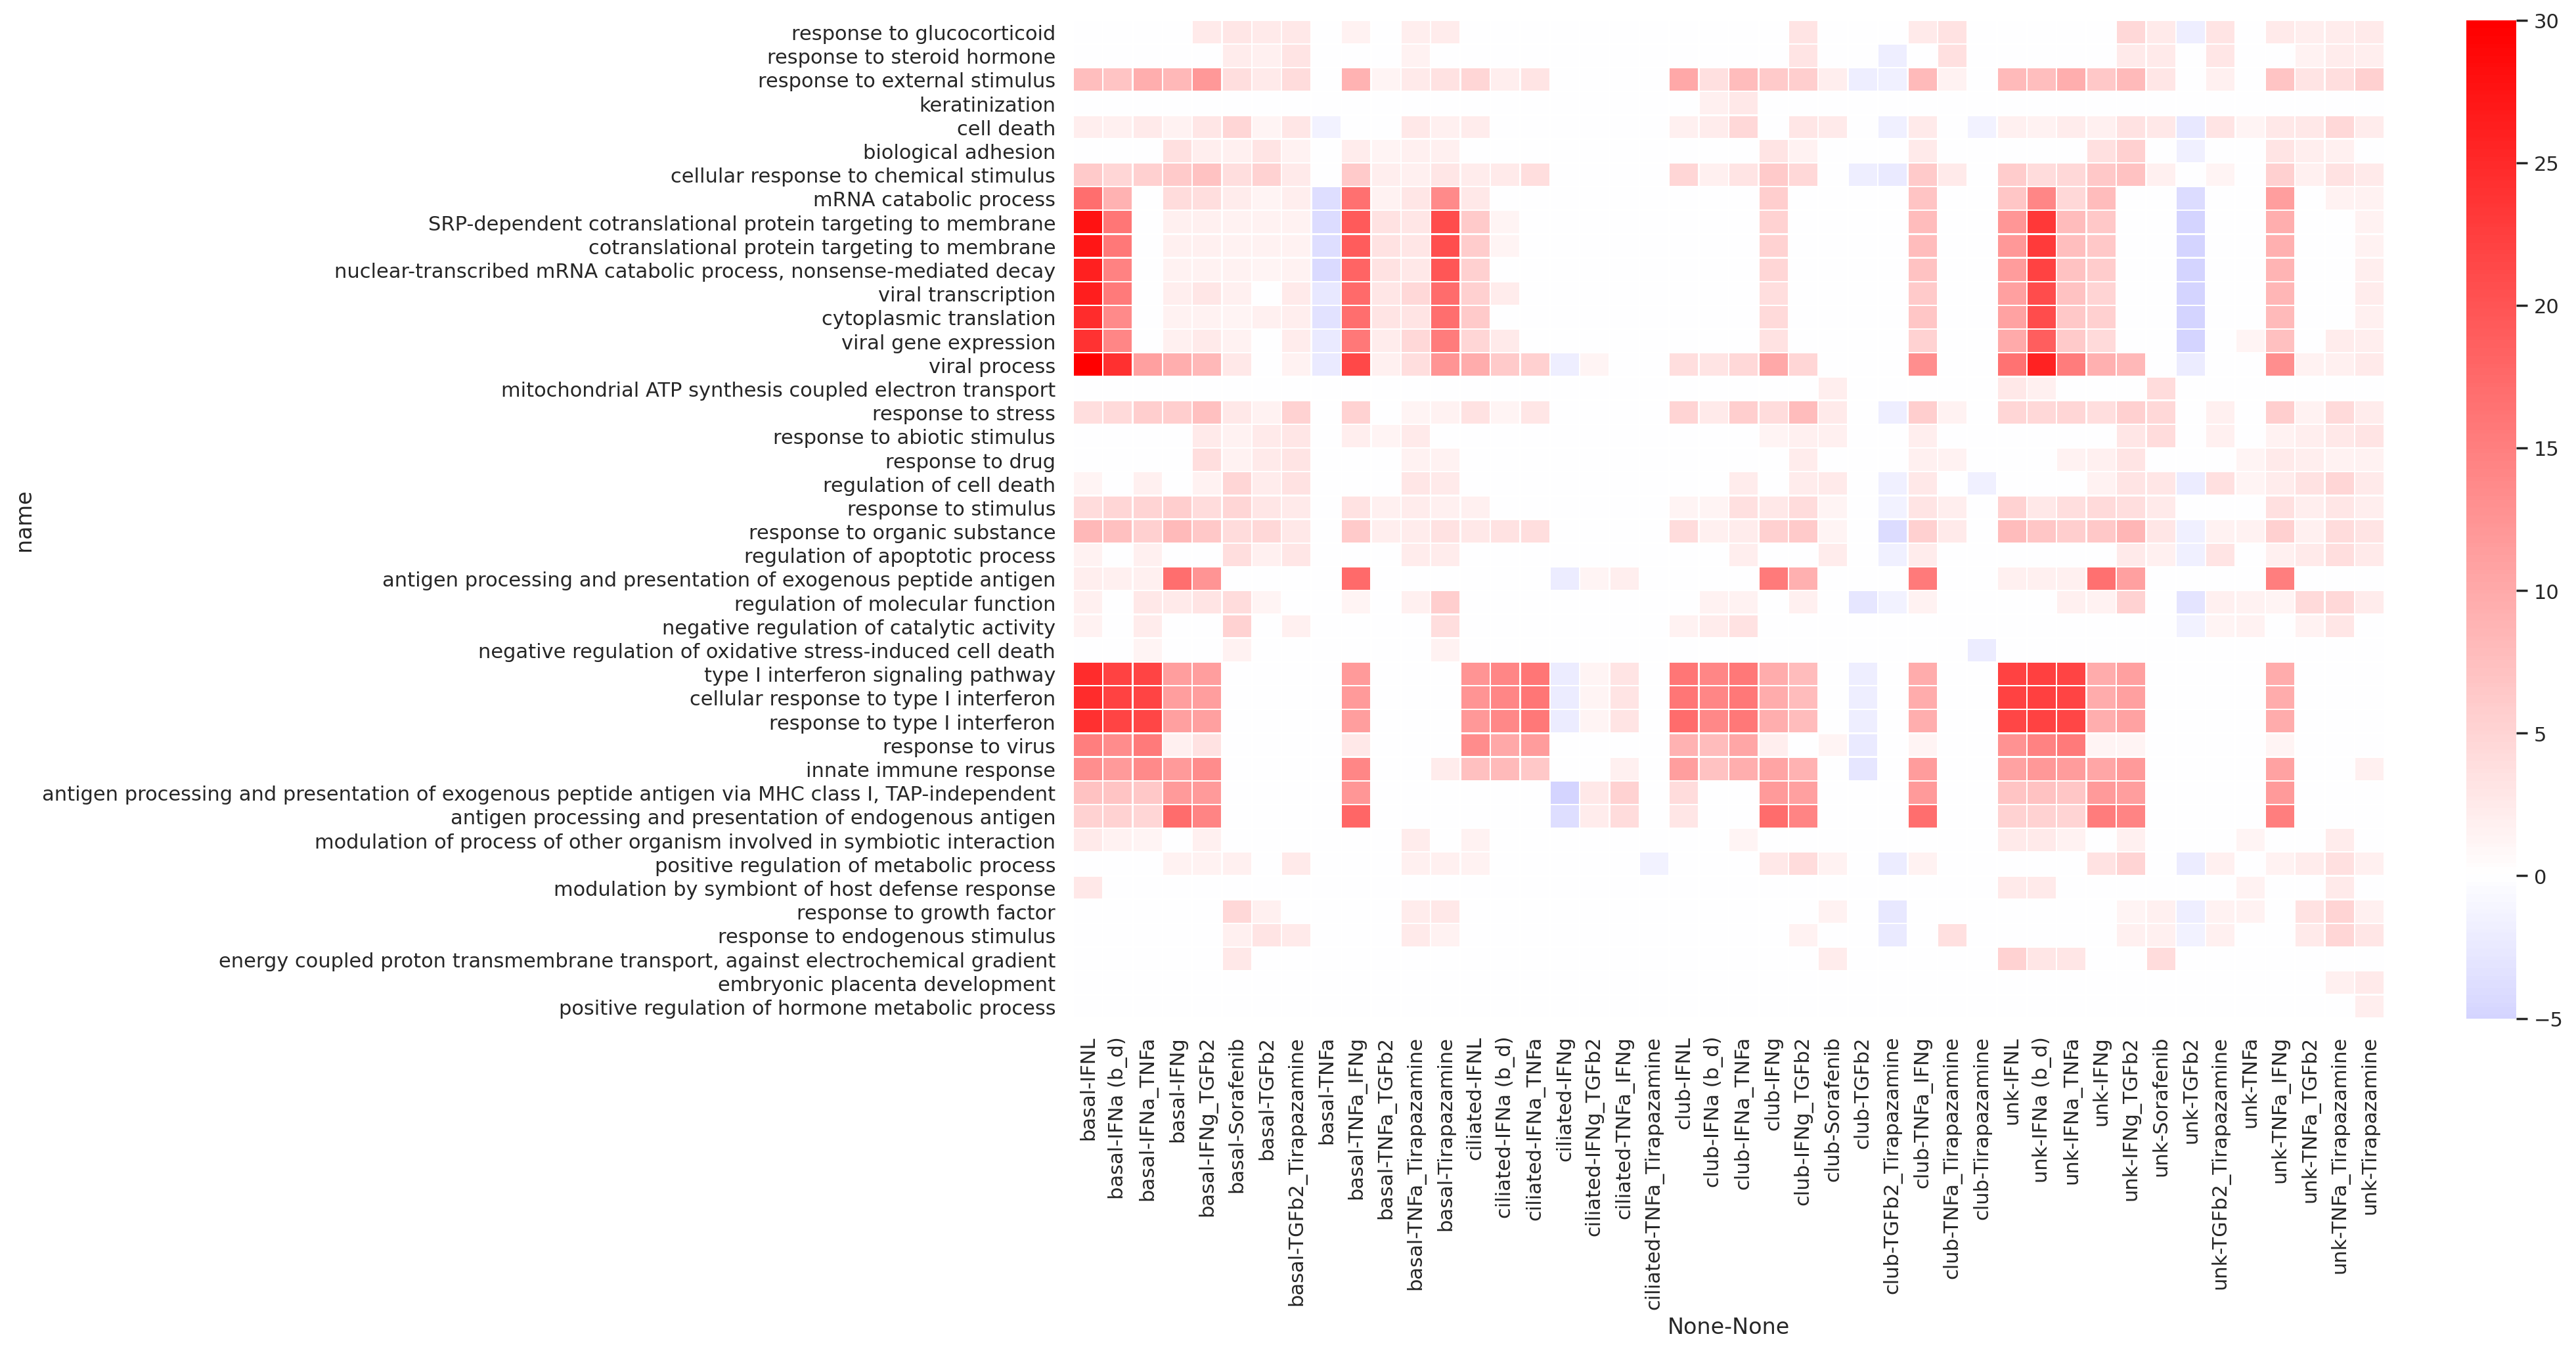

In [165]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(df[False], cmap='bwr', center=0, linewidths=.5, vmax=30, vmin=-5)

<AxesSubplot:xlabel='None-None', ylabel='name'>

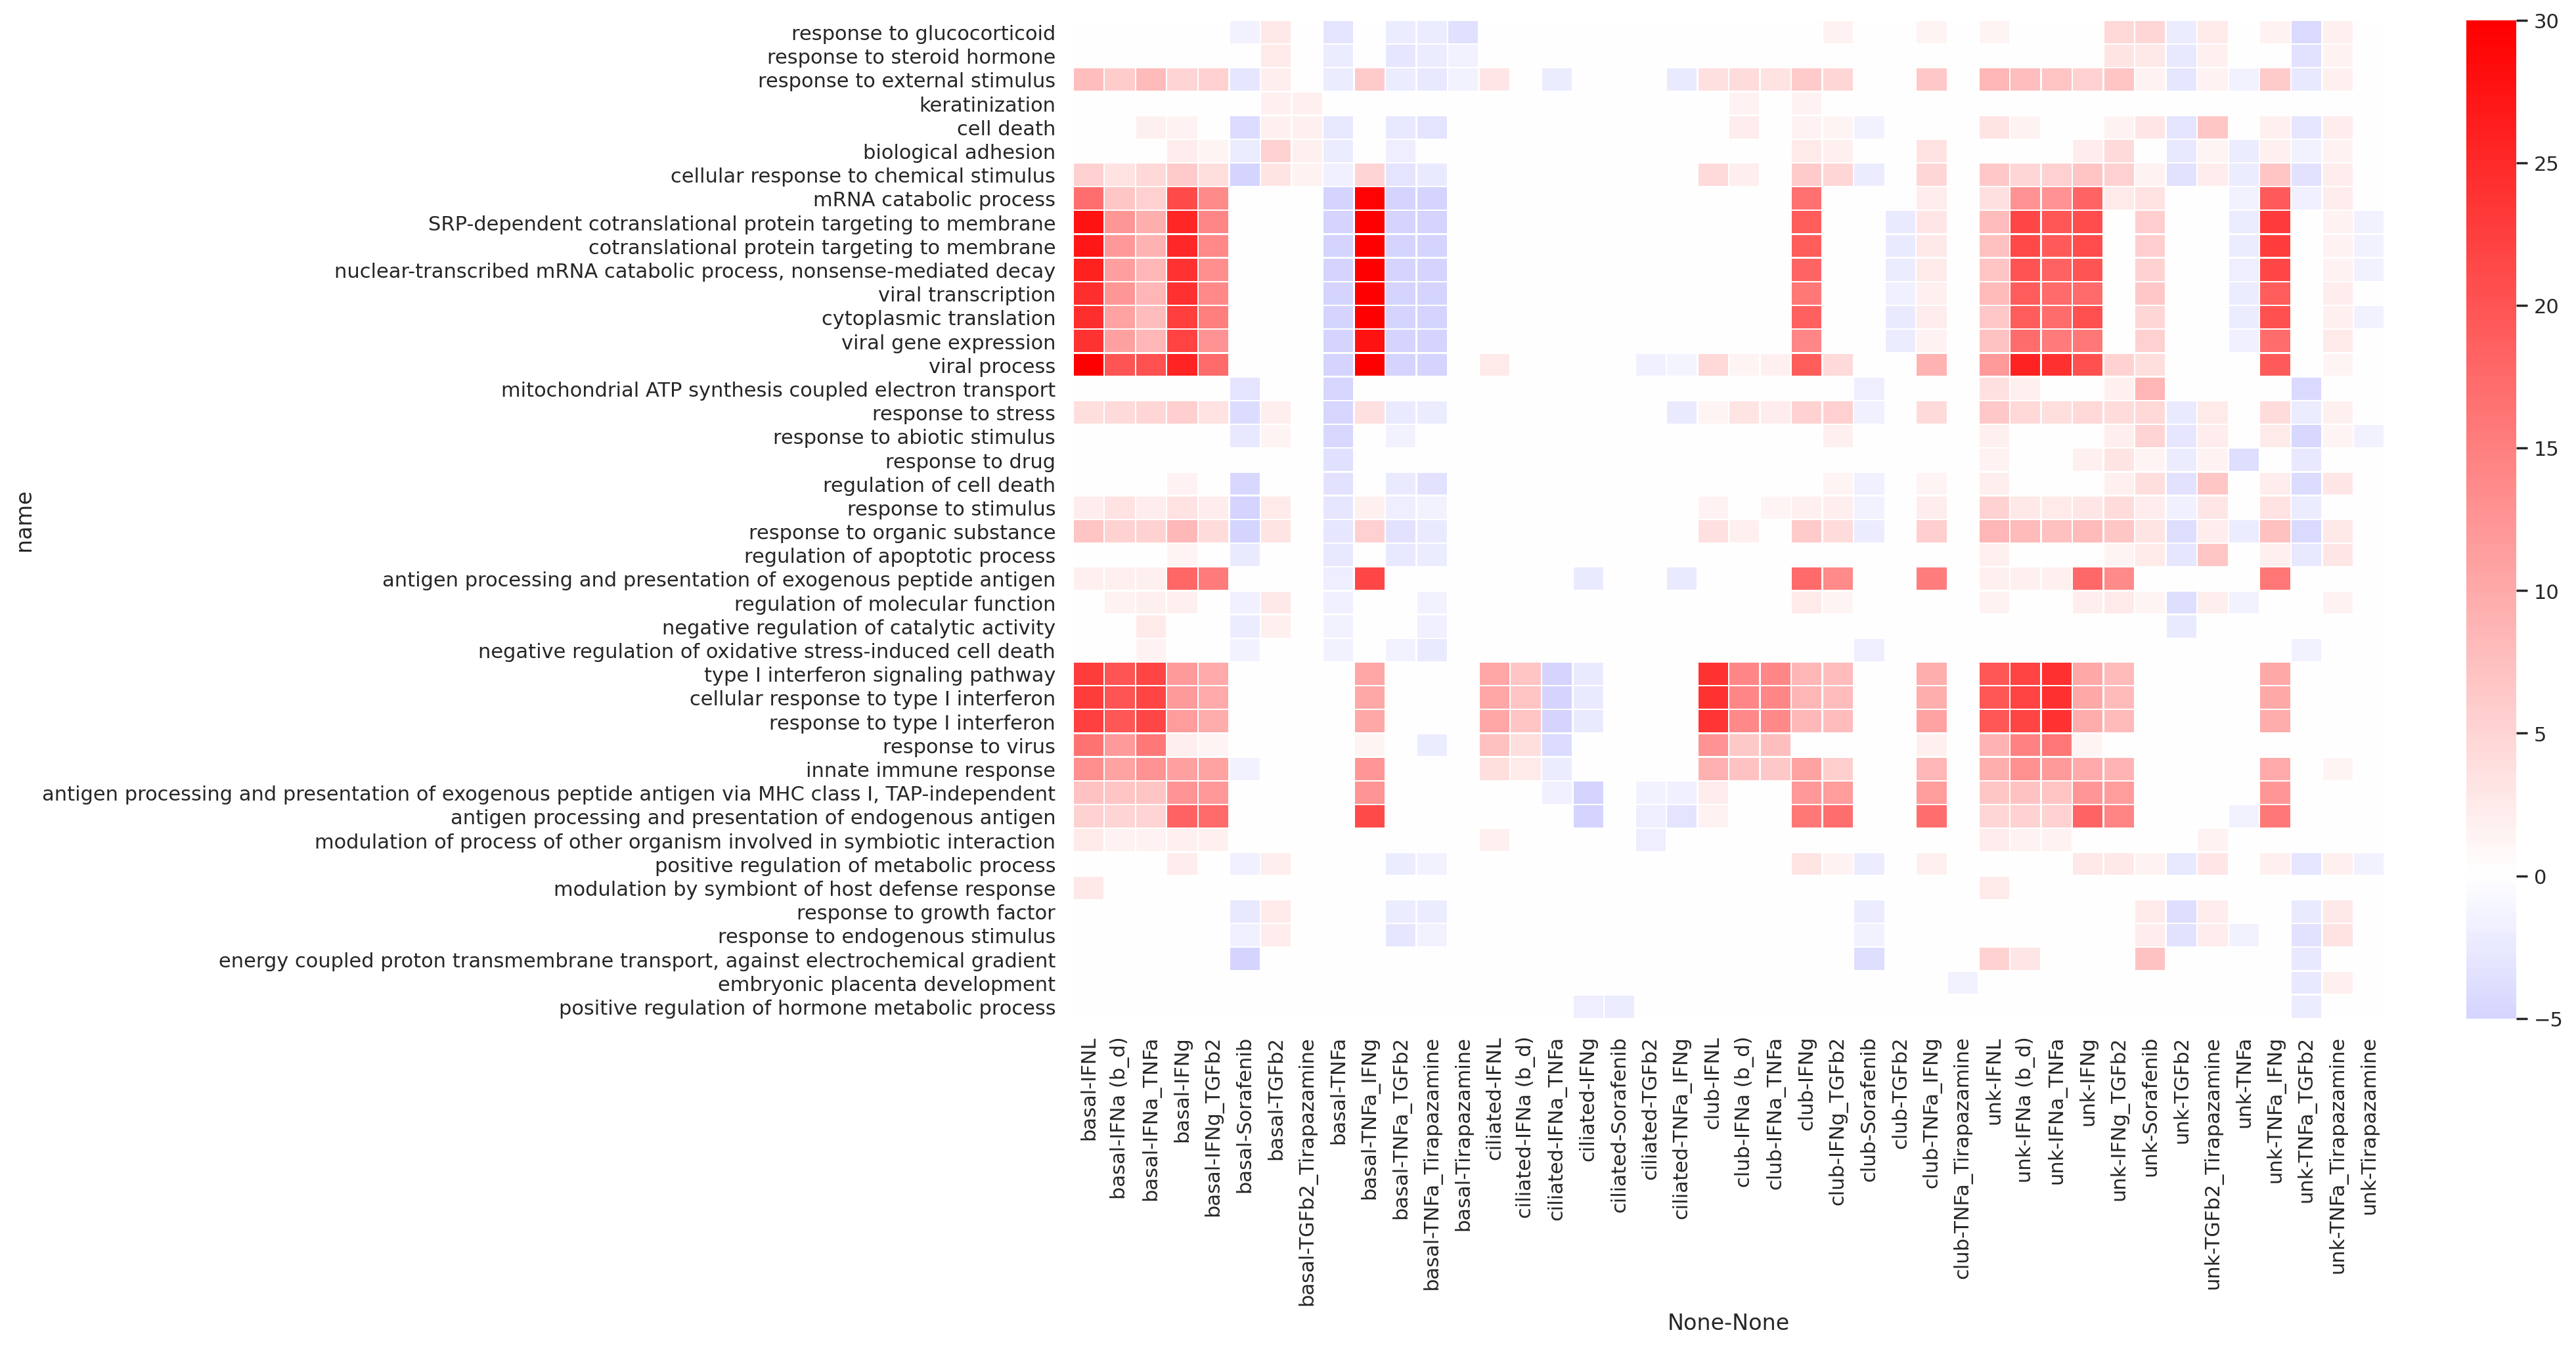

In [166]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(df[True], cmap='bwr', center=0, linewidths=.5, vmax=30, vmin=-5)

#### infected vs. uninfected

For each condition, calculate the difference in the condition between infected and uninfected.

In [70]:
inf_degs = {}
inf_dfs = {}
for ct in adata.obs.cell_type.unique():
    ct_subset = adata[adata.obs.cell_type == ct]
    for t in adata.obs.treatment.unique():
        if t == 'nan' or t == 'DMSO':  # for some reason DMSO only has infected samples
            continue
        subset = ct_subset[ct_subset.obs.treatment == t]
        if subset.shape[0] < 300:
            continue
        sc.tl.rank_genes_groups(subset, groupby='infected', reference='False')

        inf_dfs[(ct, t)] = sc.get.rank_genes_groups_df(subset, group='True')
        inf_degs[(ct, t)] = list(inf_dfs[(ct, t)].names.values[:25]) + list(inf_dfs[(ct, t)].names.values[-25:])

Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


In [71]:
%%time
df = plot_deg_heatmap(inf_degs)

CPU times: user 3.05 s, sys: 441 ms, total: 3.49 s
Wall time: 2min 54s


Combine terms from all patients.

In [56]:
# %%time
# dfs = {
#     **{('p1', k[0], k[1]): v for k, v in patient_inf_dicts['patient_1_dfs'].items()},
#     **{('p2', k[0], k[1]): v for k, v in patient_inf_dicts['patient_2_dfs'].items()},
#     **{('p3', k[0], k[1]): v for k, v in patient_inf_dicts['patient_3_dfs'].items()},
#     **{('p4', k[0], k[1]): v for k, v in patient_inf_dicts['patient_4_dfs'].items()}
# }
# enrichment = plot_deg_heatmap_bi(dfs)

CPU times: user 4.57 s, sys: 173 ms, total: 4.74 s
Wall time: 3min 48s


In [80]:
# %%time
# degs = {
#     **{('p1', k[0], k[1]): v for k, v in patient_inf_dicts['patient_1_degs'].items()},
#     **{('p2', k[0], k[1]): v for k, v in patient_inf_dicts['patient_2_degs'].items()},
#     **{('p3', k[0], k[1]): v for k, v in patient_inf_dicts['patient_3_degs'].items()},
#     **{('p4', k[0], k[1]): v for k, v in patient_inf_dicts['patient_4_degs'].items()}
# }

# # plot according to up/down of overlapping genes
# plot_values = []
# for idx in enrichment.index:
#     overlap = enrich(degs[idx[:3]]).set_index('name').loc[idx[-1]].intersections
#     condition_df = dfs[idx[:3]].set_index('names').loc[overlap]
#     v = [1 if x > 0 else -1 for x in condition_df.scores.values] # turn to 1/-1
#     plot_values.append(np.array(v).sum())

CPU times: user 56.3 s, sys: 1.62 s, total: 57.9 s
Wall time: 39min 42s


In [81]:
# # replace p_value with the inverse if there are more downregulated genes
# df = enrichment.copy()
# df['p_value'] = [-v if plot_values[i] < 0 else v for i, v in enumerate(enrichment['p_value'].values)]
# df = df.unstack(level=-1).fillna(0)
# df = df.reset_index().drop('level_0', axis=1).groupby(['level_1', 'level_2']).median()
# df = df.T.reset_index(level=0, drop=True)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='level_1-level_2', ylabel='name'>

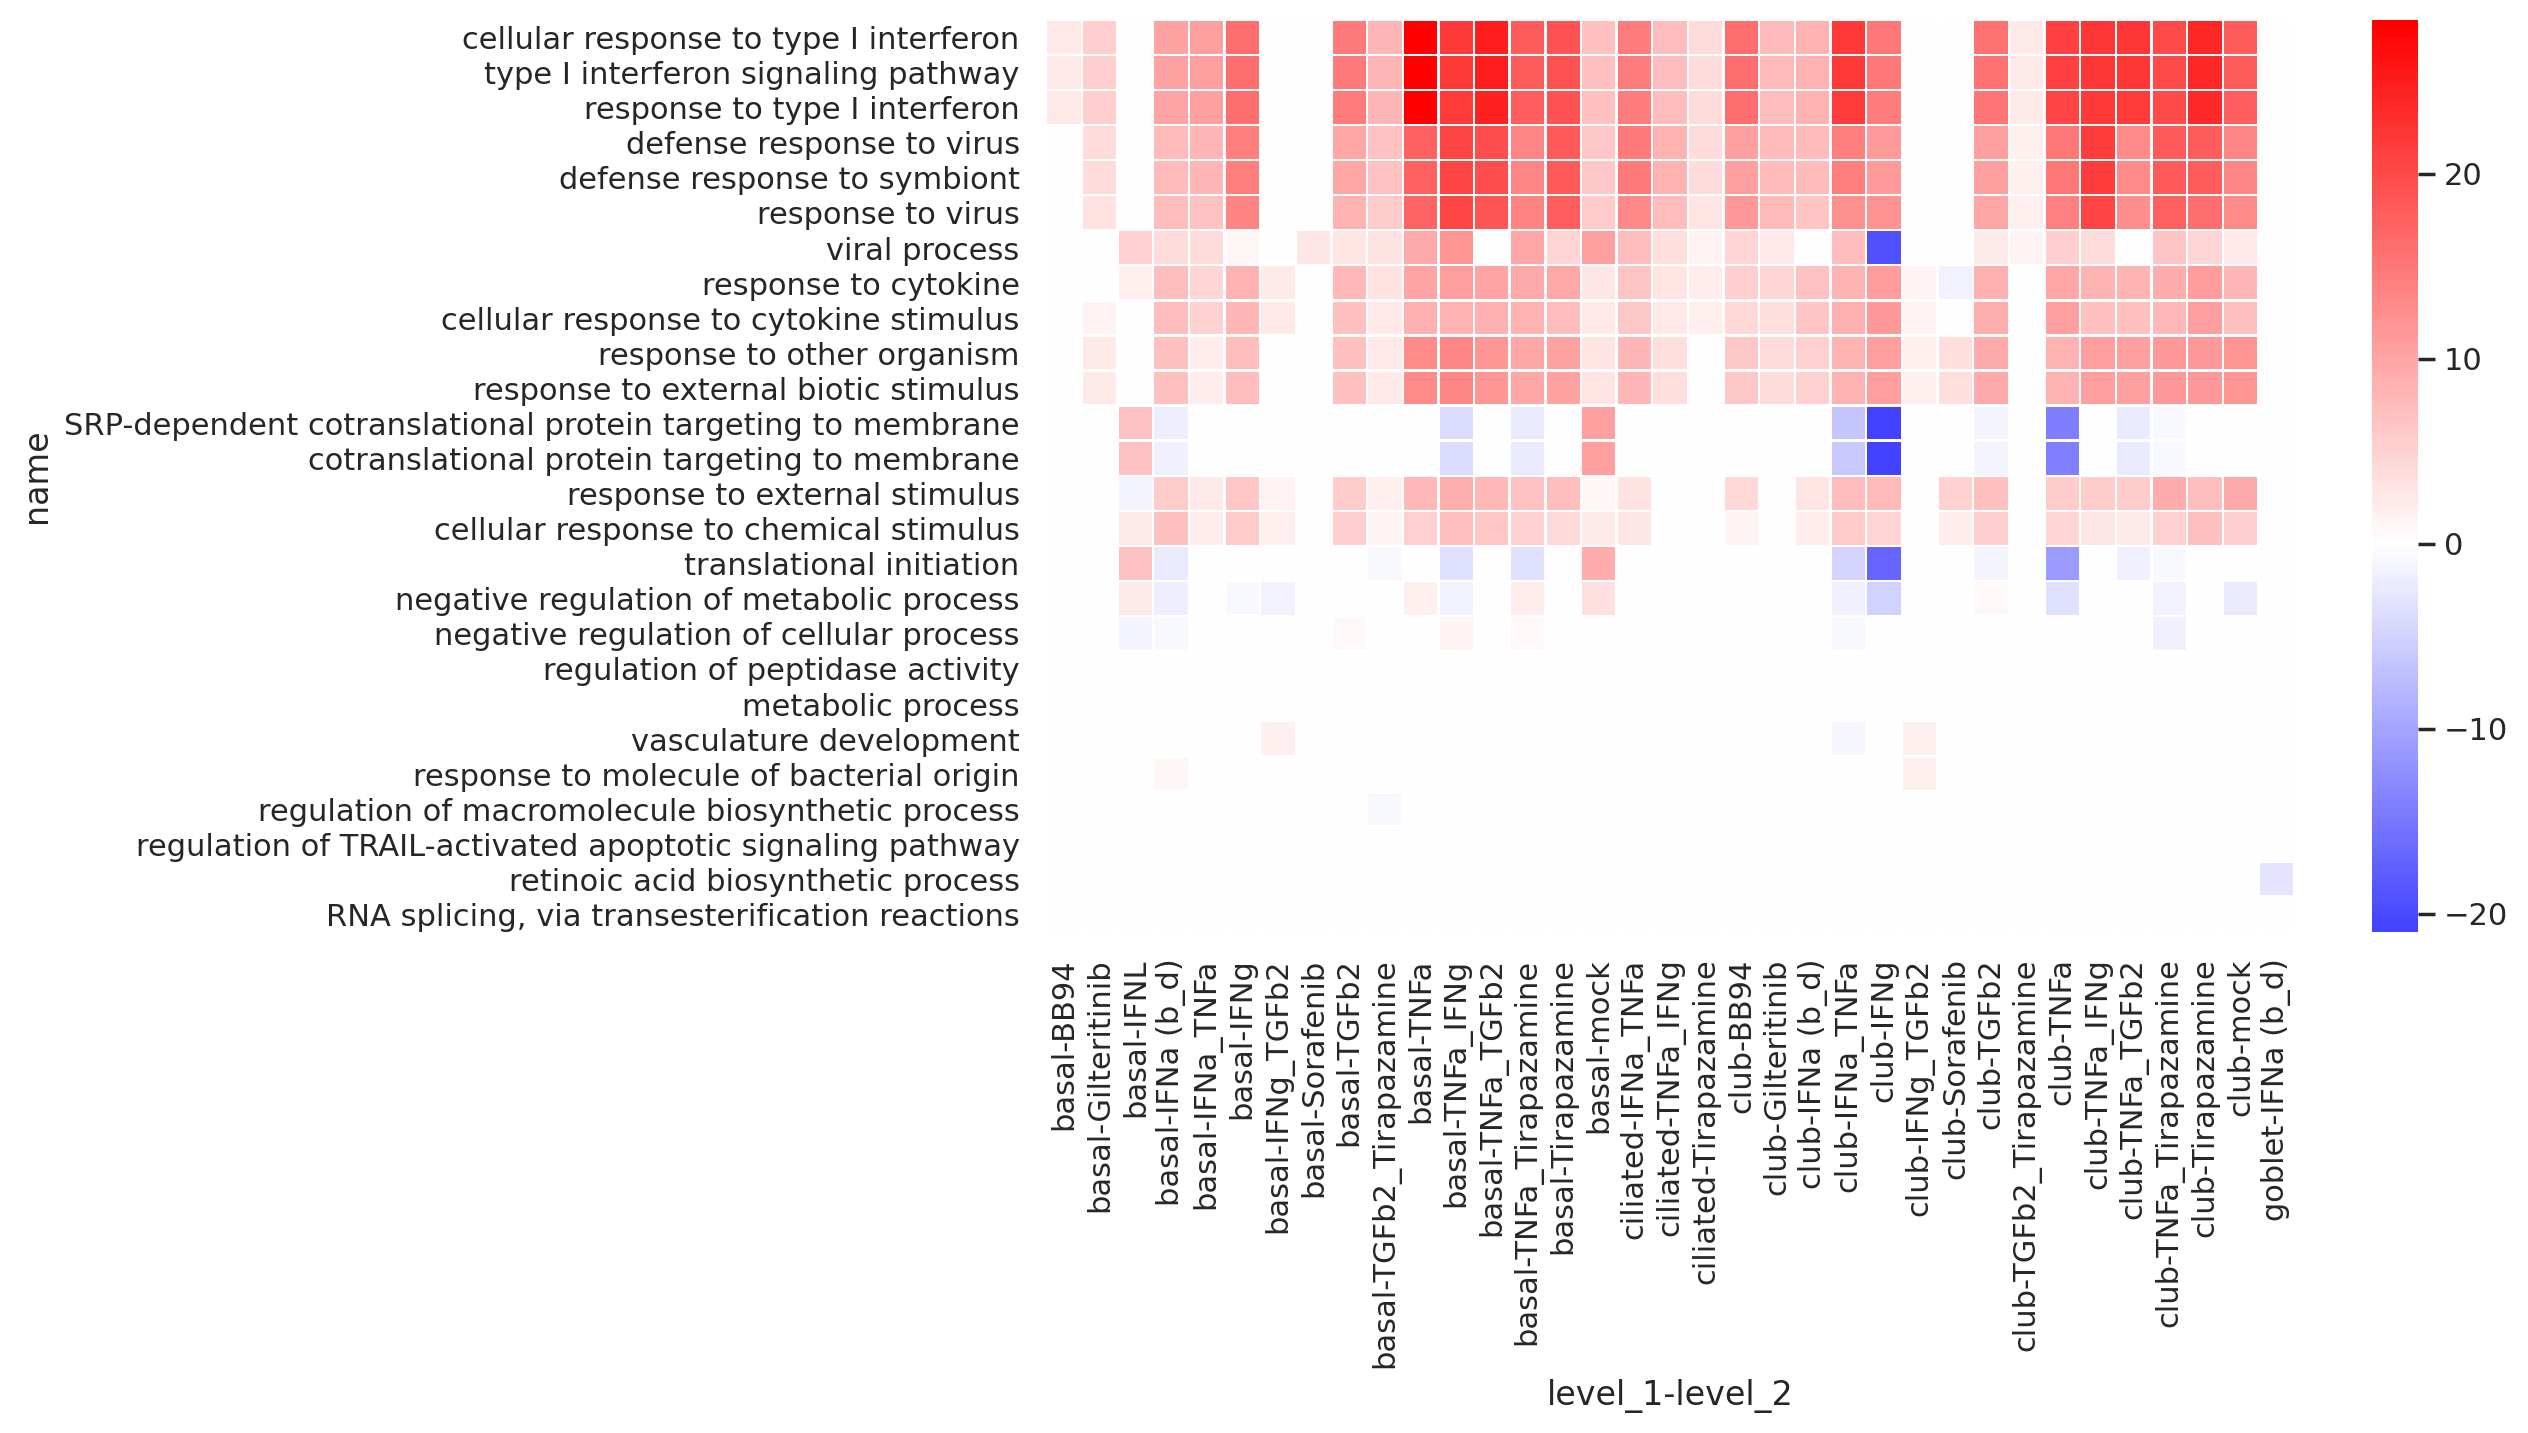

In [84]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(df, cmap='bwr', center=0, linewidths=.5)#, vmax=30, vmin=-5)

#### Number of differentially expressed genes per condition

As a proxy to responsiveness, get the number of siginificantly differentially expressed genes per condition, as defined by pvalue < .05 and logfold change > 2.

In [60]:
nsigs = []
for (c1, c2, c3), df in dfs.items():
    nsigs.append((
        c1, c2, c3,
        df[(df.pvals < .05) & (df.logfoldchanges > 2)].shape[0]
    ))

In [62]:
df = pd.DataFrame(nsigs)
df.columns = ['infected', 'cell_type', 'treatment', 'n_sig']

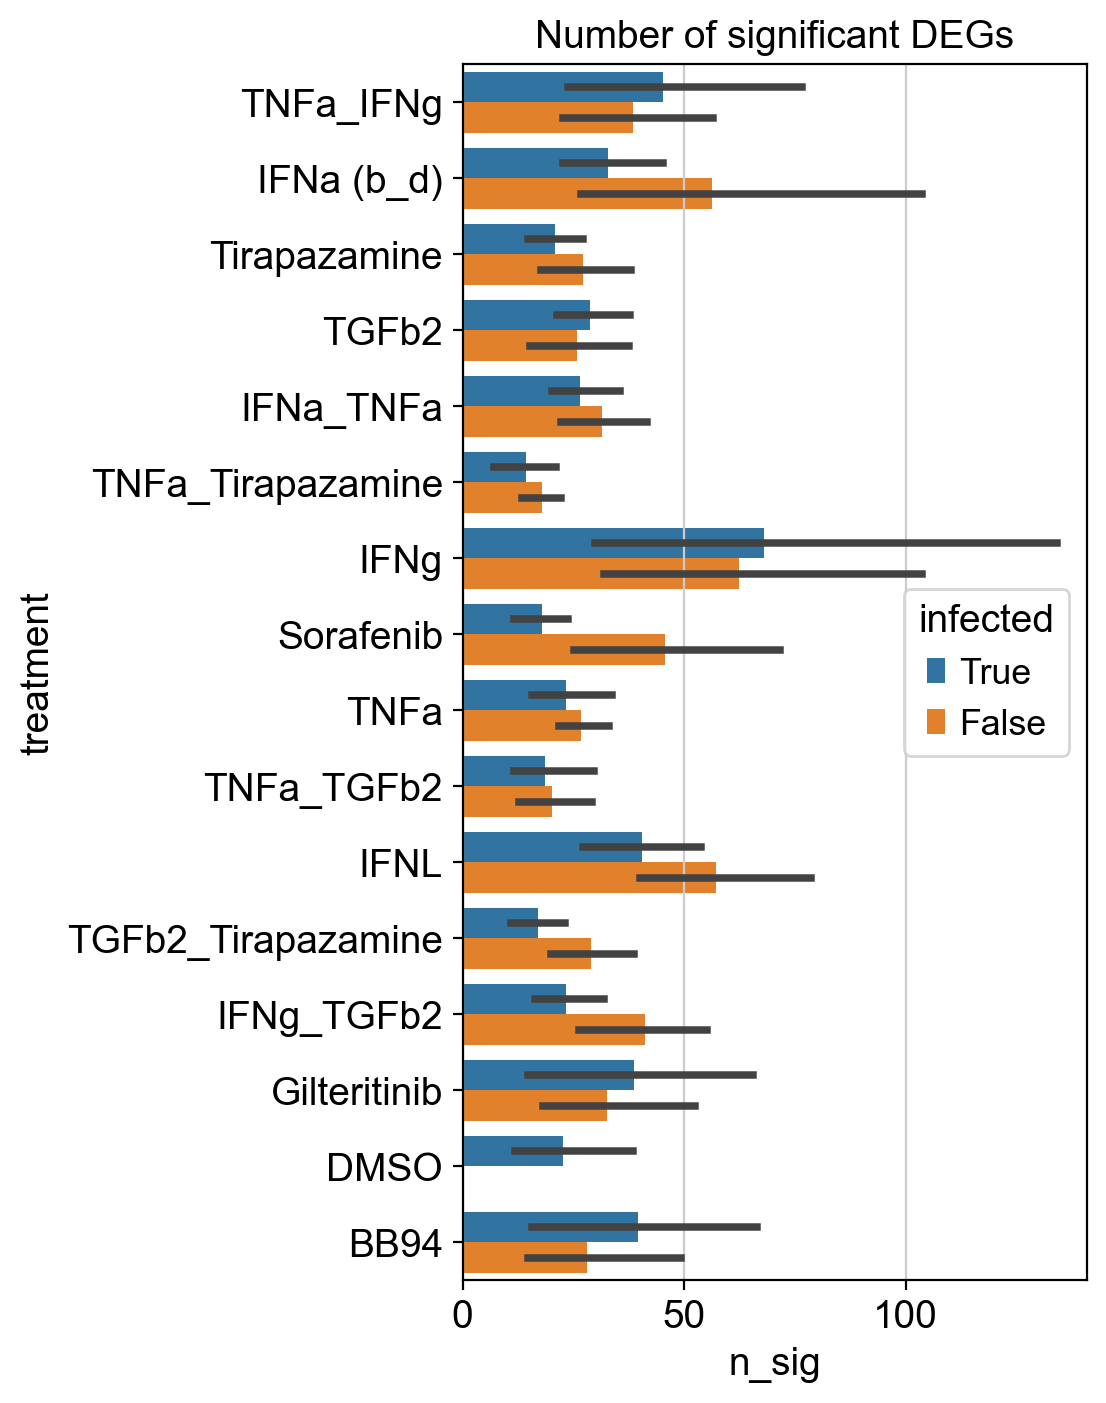

In [68]:
plt.figure(figsize=(4, 8))
sns.barplot(data=df, x='n_sig', y='treatment', hue='infected')
plt.title('Number of significant DEGs');

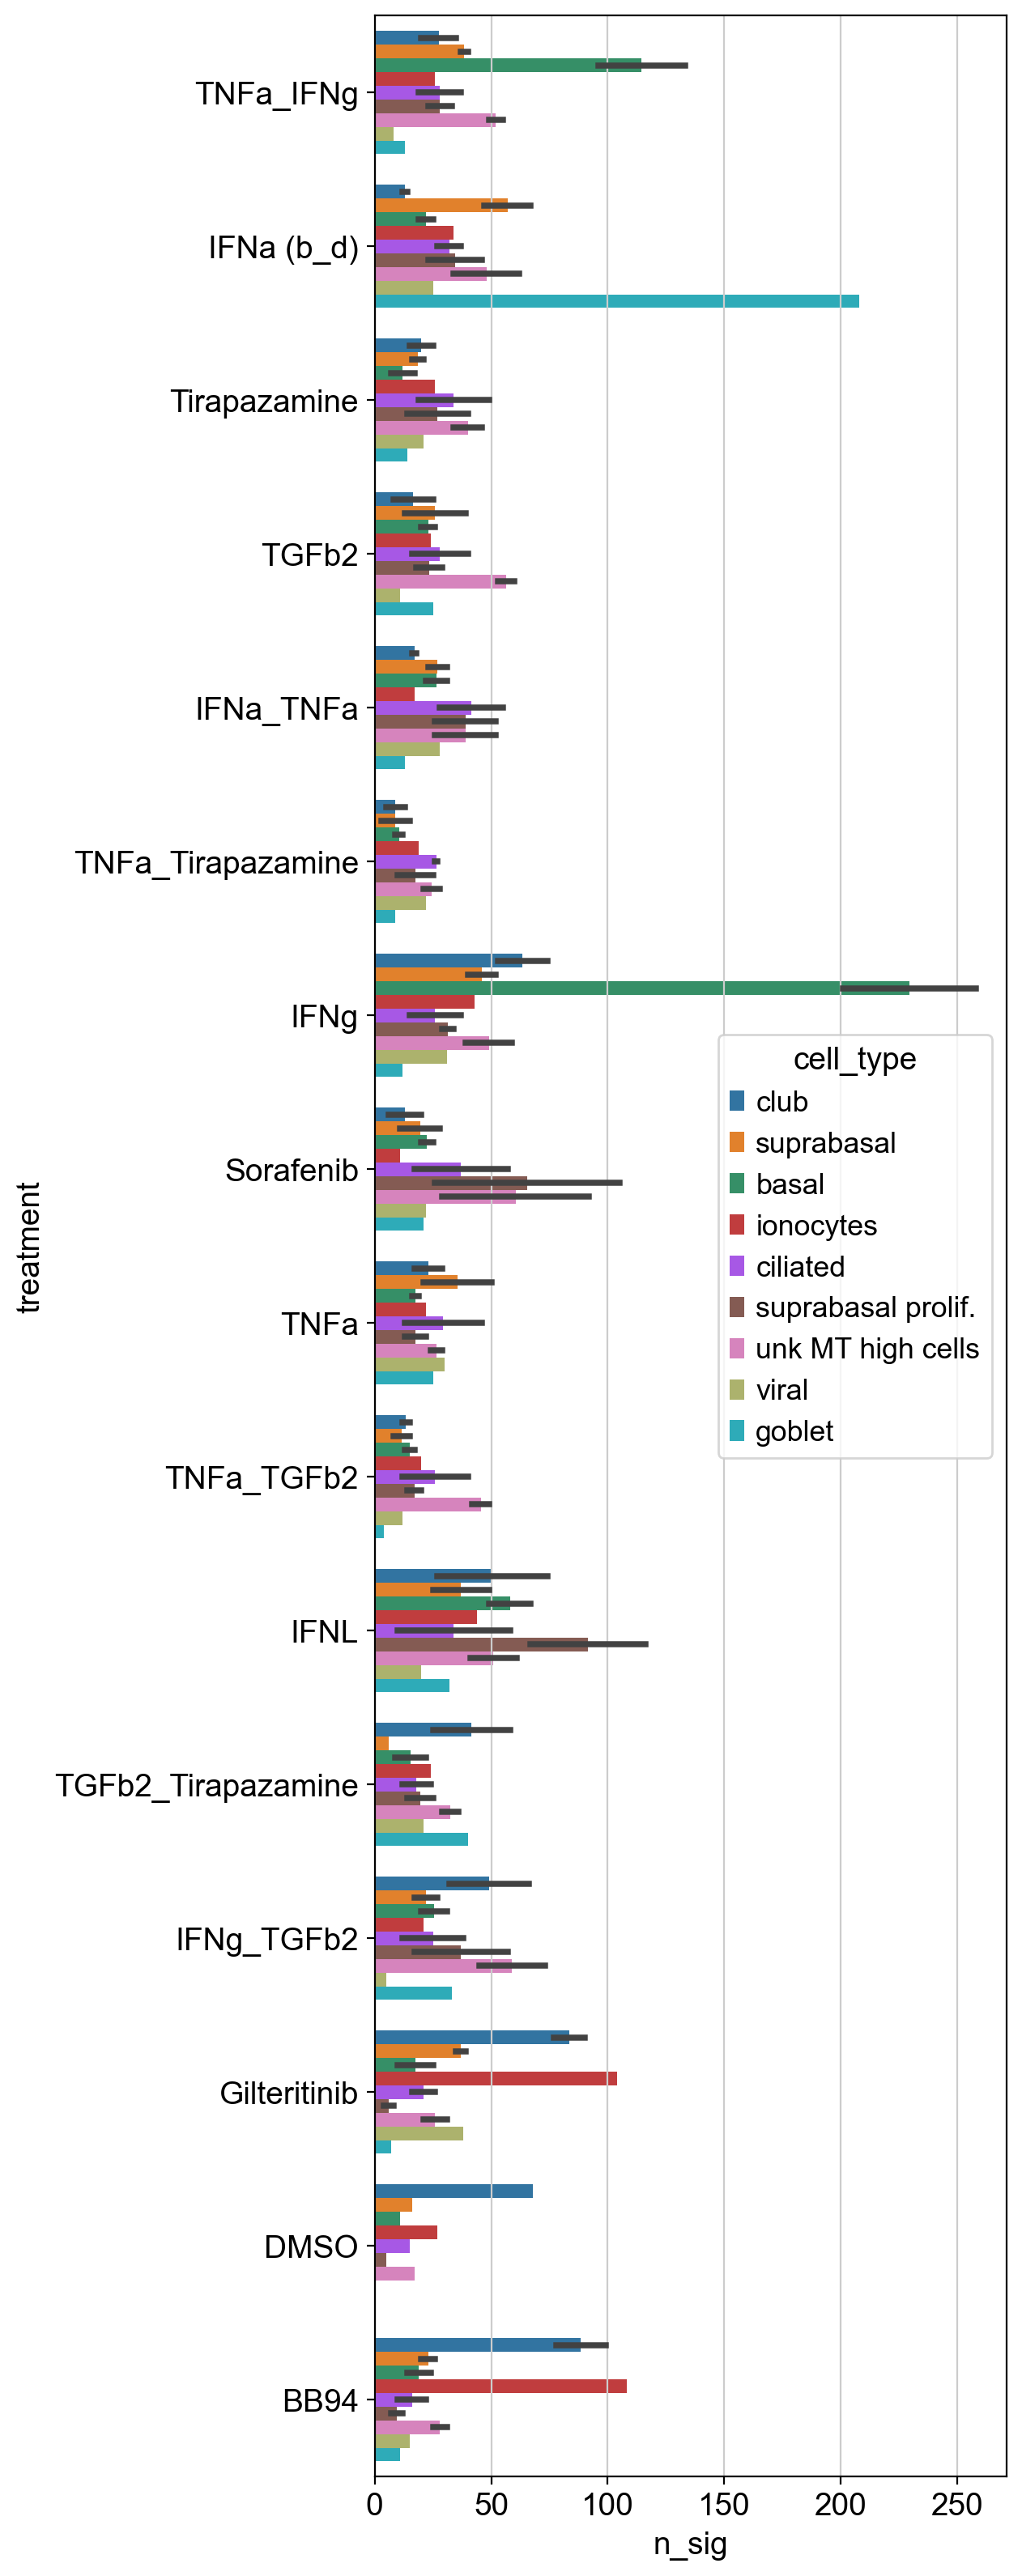

In [65]:
plt.figure(figsize=(5, 20))
sns.barplot(data=df, x='n_sig', y='treatment', hue='cell_type');

### using diffxpy

In [38]:
diffxpy_degs = {}
for t in adata.obs.treatment.unique():
    if t == 'mock':
        continue
    test_tt = de.test.t_test(
        data=adata[adata.obs.treatment.isin([t, 'mock'])],
        grouping="treatment",
        is_logged=True,
    )
    diffxpy_degs[t] = list(test_tt.summary().sort_values(by='pval')['gene'].values[:50])

In [39]:
%%time
df = plot_deg_heatmap(diffxpy_degs)

CPU times: user 1 s, sys: 63.8 ms, total: 1.07 s
Wall time: 34.2 s


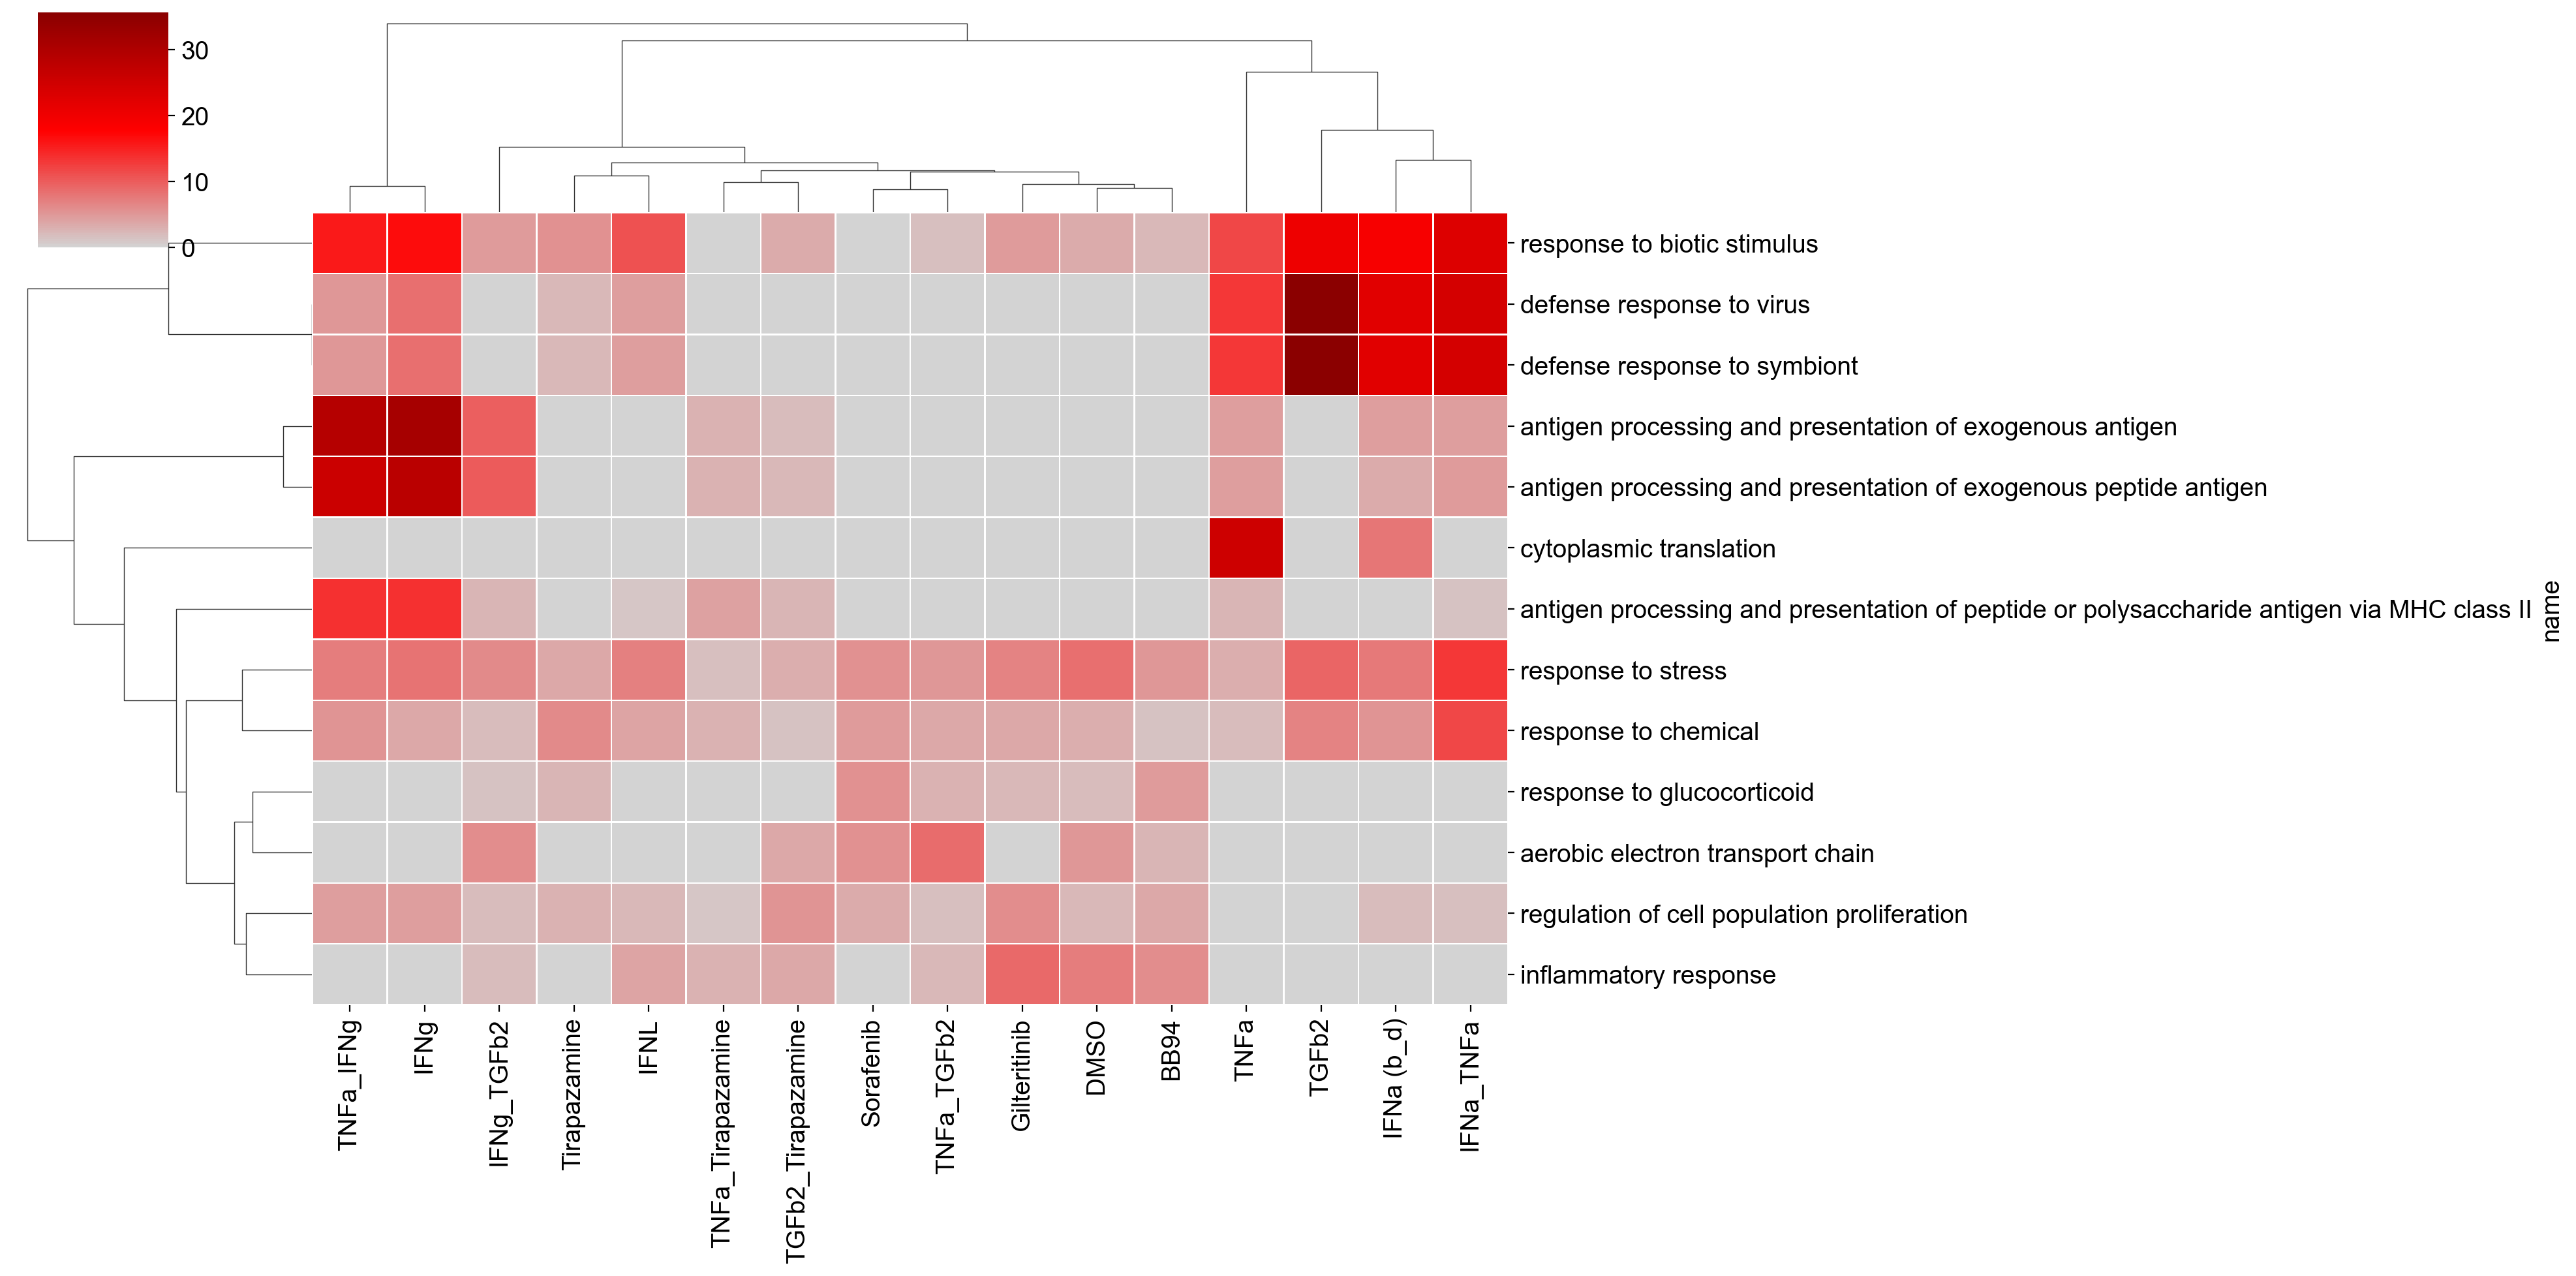

In [47]:
sns.clustermap(
    df,
    cmap=gray_red,
    linewidths=.5,
    figsize=(20, 10)
)

/home/icb/yuge.ji/diffxpy/diffxpy/testing/det.py:151: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qvals = np.reshape(self.qval, -1).astype(dtype=np.float)


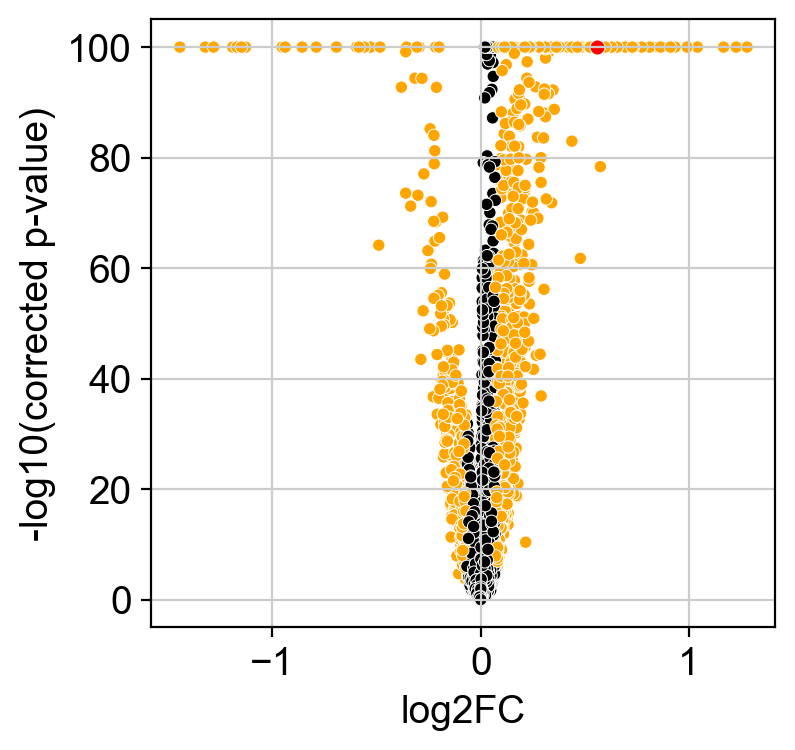

In [16]:
test_tt.plot_volcano(
    corrected_pval=True, min_fc=1.05, alpha=0.05, size=20, log10_p_threshold=-100, log2_fc_threshold=10,
    highlight_ids=['CD74'])

## Write to excel tables

### Pseudo-bulk

To imitate bulk, sum the counts of the genes for all the cells, per sample breakdown.

In [6]:
adata = adata.copy()  # necessary to avoid error... might've saved a view
adata.X = adata.layers['counts']

The txt file should contain five columns: “gene”, “patient”, “treatment”, “infected”, “count” (cell-type optional)

In [13]:
data = adata.to_df()
data['patient'] = adata.obs['patient']
data['infected'] = adata.obs['infected']
data['cell_type'] = adata.obs['cell_type']
data['treatment'] = adata.obs['treatment']

Per cell type per treatment per infection.

In [14]:
%%time
writer = pd.ExcelWriter('14-03_bulkified_data.xlsx', engine='xlsxwriter')

# write into excel sheet
data.groupby(['patient', 'infected', 'treatment']).mean().T.to_excel(writer, sheet_name='mean')
data.groupby(['patient', 'infected', 'treatment']).median().T.to_excel(writer, sheet_name='median')
data.groupby(['patient', 'infected', 'treatment', 'cell_type']).mean().T.to_excel(writer, sheet_name='mean_celltype')
data.groupby(['patient', 'infected', 'treatment', 'cell_type']).median().T.to_excel(writer, sheet_name='median_celltype')

writer.close()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='14-03_bulkified_data.xlsx'>
  """Entry point for launching an IPython kernel.


CPU times: user 10min 13s, sys: 5min 11s, total: 15min 25s
Wall time: 15min 30s


### Differential expression summary

In [84]:
# writer = pd.ExcelWriter('diff_expr_data.xlsx', engine='xlsxwriter')
# for p in ['patient_1_2', 'patient_3', 'patient_4']:
#     diff_dfs = {}
#     for k, v in patient_dicts[f'{p}_dfs'].items():
#         diff_dfs[k] = v.set_index('names')[['scores']]  # dictionary of dataframes
    
#     # write
#     pd.concat(diff_dfs).unstack(level=-1).loc[False].T.to_excel(writer, sheet_name=f'{p}_uninfected')
#     pd.concat(diff_dfs).unstack(level=-1).loc[True].T.to_excel(writer, sheet_name=f'{p}_infected')
# writer.close()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='diff_expr_data.xlsx'>
  """Entry point for launching an IPython kernel.
